In [1]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')

%colors nocolor

In [2]:
def get_and_store_raw_data(fromCSV, numberOfStocks=50, daysSince=30):
    tickers_df = retrieve.get_tickers(numberOfStocks)
    
    if (fromCSV):
        (rawdata, spreads, volumes) = retrieve.get_from_CSV()
    else:
        downloadedData = retrieve.get_downloaded_data(tickers_df, numberOfStocks, daysSince)
        (rawdata, spreads, volumes) = retrieve.distribute_data(downloadedData)
        retrieve.save_data(rawdata, spreads, volumes)

    return (rawdata, spreads, volumes, tickers_df)
    
def processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2):
    print ("Calculating indicators...")
    companies = closes.columns.values

    EMA_df = calc.get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, closes)
    OBV_df= calc.get_OBV_df(volumes, closes)
    keyStats = calc.get_intersection_point(EMA_df, closes)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = calc.ratioWrapper(EMA_df, companies, keyStats)
    keyStats['latestGrowth'] = round(closes.pct_change()[-latestWindow:].min(),5)
    keyStats['ratioContr'] = calc.get_stocks_growing_now(closes, keyStats, 3)

    return(EMA_df, OBV_df, keyStats) 

import matplotlib.pyplot as plt

def plot_one_with_obv(x, EMA_df, closes, OBV_df):
    fig, axs = (plt.subplots(2, sharex=True))
    x_axis = closes.index
    axs[0].plot(x_axis, EMA_df['Quick'][x], 'r')
    axs[0].plot(x_axis, EMA_df['Slow'][x], 'b')
    axs[0].plot(x_axis, closes[x], 'g')
    axs[1].plot(x_axis, OBV_df[x], 'g')

def showData(closes, EMA_df, OBV_df, keyStats, filterSet, tickers_df):
    filteredCompanies = viz.filter_companies(keyStats, filterSet)
    filteredCompanies.to_csv("./logs/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 
    viz.plot_all(closes, EMA_df, OBV_df, filteredCompanies, tickers_df, limit=10)



In [3]:
"""
Filterset Sample. Use 0 or comment for Neutral

filterSet = dict({
    "aboveAvgRatio":1, 
    "aboveMinAbs":1, 
    "minPositivePeriod":4, 
    "ratioContr":1, 
    "latestGrowth":0.8
    })

timeframes dict({
    daysSince,
    qema_period,
    sema_period
    }) 
"""

""" filterSet = dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.005
     }) """

def get_reset_mode(numberOfStocks, daysSince, filterSet):
    global  search_params_cache, filter_params_cache, keyStats
    
    search_params_current = dict(numberOfStocks=numberOfStocks, daysSince = daysSince)
    resetMode = 0
    if (('filter_params_cache' not in globals()) or ('keyStats' not in globals()) or (filterSet != filter_params_cache)): resetMode = 1
    if (('search_params_cache' not in globals()) or ('closes' not in globals()) or (search_params_current != search_params_cache)): resetMode = 2

    search_params_cache = search_params_current
    filter_params_cache = filterSet
    #print (f"Reset mode is {resetMode}")
    return (resetMode)

def find_stocks(filterSet, numberOfStocks=500, daysSince=30):
    global closes, spreads, volumes, EMA_df, OBV_df, keyStats, tickers_df

    resetMode = get_reset_mode(numberOfStocks=numberOfStocks, daysSince=daysSince, filterSet=filterSet)
    fromCSV = False

    if (resetMode == 2):
        print ("Raw data did not exist or search params were changed. Downloading...")
        fromCSV = retrieve.from_CSV(daysSince, numberOfStocks)

        (closes, spreads, volumes, tickers_df)= get_and_store_raw_data(fromCSV=fromCSV, numberOfStocks=numberOfStocks, daysSince=daysSince)

    if (resetMode >= 1):
        print ("Filters and processed data did not exist or search params were changed. Processing...")
        (EMA_df, OBV_df, keyStats) = processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2)


    showData(closes, EMA_df, OBV_df, keyStats, filterSet, tickers_df)
    
    return (closes, spreads, volumes, EMA_df, keyStats, tickers_df)

#(closes, spreads, EMA_df, keyStats) = find_stocks(filterSet)



In [4]:
#all(var in globals() for var in ['filter_params_cache', 'search_params_cache'])
#del(closes)

Raw data did not exist or search params were changed. Downloading...
Is it possible to use cached data? True
Returning stored data.
Filters and processed data did not exist or search params were changed. Processing...
Calculating indicators...
--> EMA Dataframe calculated.
--> Intersection points found.
--> Absolute and Relative Mins calculated.
Starting filtering...
--> Main companies filtered. 1 outstanding companies.
Displaying 1 first companies
Company ACN


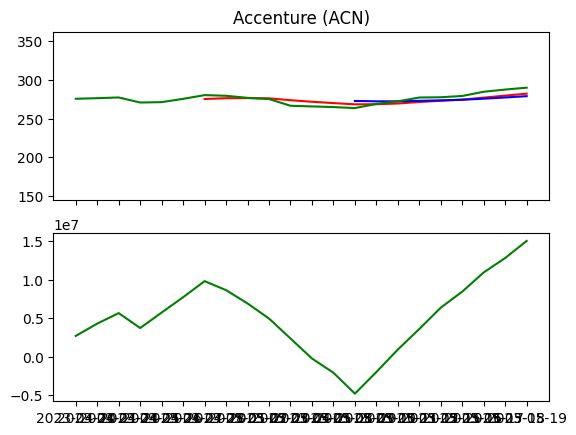

In [5]:
(closes, spreads, volumes, EMA_df, keyStats, tickers_df) = find_stocks(numberOfStocks=5, filterSet=dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, #Originally 0.0001 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.0001 #Originally 0.005
     }))

In [6]:
difference = (OBV_df[-5:].mean()-OBV_df.mean())
ratio = difference /(OBV_df.mean().abs())
finalList = ratio.sort_values(ascending=False)
finalList

ACN     1.115142
ABT    -0.169061
MMM    -0.801846
AOS    -1.439185
ABBV   -3.629283
dtype: float64

In [7]:
OBV_df[testcompany][-5:]


NameError: name 'testcompany' is not defined

In [ ]:
testcompany = 'EXPE'
print(f"Últimos 5 días: {OBV_df[testcompany][-5:].mean()}, Rango total: {OBV_df[testcompany].mean()}")

In [ ]:
plot_one_with_obv(testcompany, EMA_df, closes, OBV_df)

In [ ]:
OBV_df.mean()

In [ ]:
OBV_df= calc.get_OBV_df(volumes, closes)

In [ ]:

closes.index[0].strftime('%Y%m%d')

In [ ]:
ts_origin = ts_today - pd.Timedelta(days=30)
ts_origin.strftime('%Y%m%d')